In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from lisflood_read_plot import *

from reservoirs_lshm.utils.plots import plot_resops, reservoir_analysis

## Config

In [3]:
PATH_TESTS = Path('Z:/nahaUsers/casadje/GloFASv5/reservoirs/tests')

catchment = '629'
# test = 'out_v5test4_deapup_newLAIIirrigMaps_RES_TL_MCT'
test = 'out_MCT_TL_ResRF/long_term_run_for_checks'
PATH_RESULTS = PATH_TESTS / catchment / test

PATH_OBS = Path('Z:/nahaUsers/casadje/datasets/Kazakhstan/reservoirs/timeseries/processed')

## Records

In [21]:
observed = pd.read_csv(PATH_OBS / 'shardara.csv', parse_dates=True, index_col='date')
observed.rename(columns={'inflow m3/sec': 'inflow', 'discharge m3/sec': 'outflow', 'volume million/m3': 'filling'}, inplace=True)
observed.filling /= 6700 # 5200 hm3 according to Kazakhstan

observed = {288: observed}

observed[288].head()

,inflow,outflow,filling
date,,,
2012-01-01,1342.648148,1007.0,0.565373
2012-01-02,1342.648148,1007.0,0.569701
2012-01-03,1423.666667,1007.0,0.574030
2012-01-04,1238.481481,1007.0,0.579403
2012-01-05,1527.833333,1007.0,0.582388


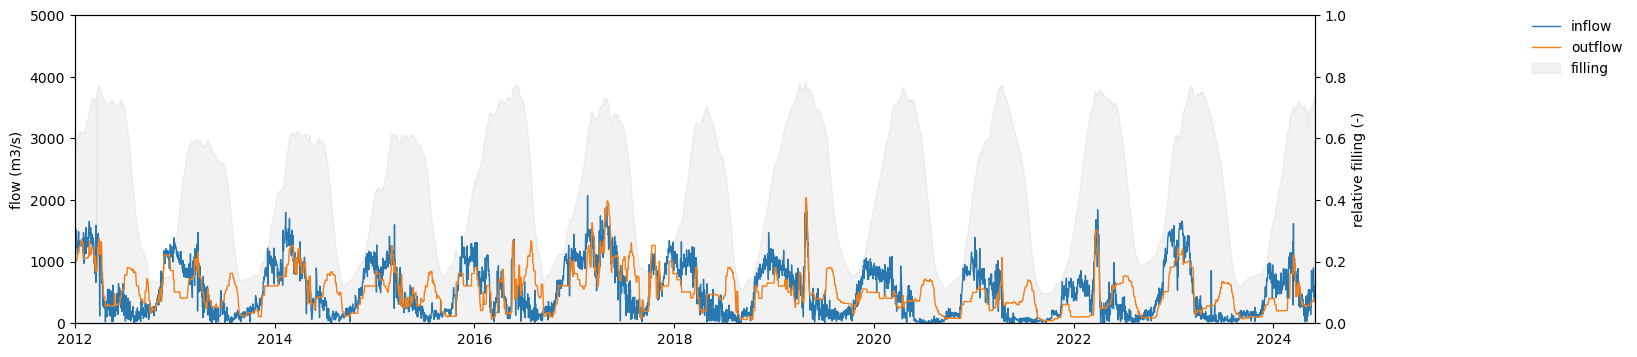

In [27]:
plot_reservoir(observed[288])

## Model

### Time series

In [9]:
# files to be read
tss_files = {
    'resfill': 'filling',
    'qresin': 'inflow',
    'qresout': 'outflow',
    # 'withdrawalReservoirsTS': 'withdrawal'
}

# find settings file
try:
    settings_file = list(PATH_RESULTS.glob('*.xml'))[0]
except:
    settings_file = None

# read results
results = {}
for file, variable in tss_files.items():
    df = read_tss(
        tss=PATH_RESULTS / f'{file}.tss',
        xml=settings_file
    )
    df = df.replace(1e31, np.nan).dropna(axis=1, how='all')
    df.columns = df.columns.astype(int)
    results[variable] = df

# reorganize results
results = {
    ID: pd.concat([df[ID] for df in results.values()], axis=1, keys=results.keys())
    for ID in results[list(results)[0]].columns
}

### Reservoir attributes

In [10]:
attributes = []
for txt_file in (PATH_TESTS  / 'tables' / 'new').glob('reservoirs*20250228.txt'):
    print(txt_file)
    attr = pd.read_csv(txt_file, sep='\t', header=None, index_col=0)
    attr.columns = ['_'.join(txt_file.stem.split('_')[2:-1])]
    attr.index.name = 'ID'
    attributes.append(attr)
attributes = pd.concat(attributes, axis=1)
attributes = attributes.loc[results.keys()]

attributes.head()

Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_100yr_inflow_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_avg_inflow_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_capacity_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_env_flow_20250228.txt


,100yr_inflow,avg_inflow,capacity,env_flow
ID,,,,
287,966.8,168.5,19500000000,8.423
288,3387.7,849.7,6700000000,42.483
292,2779.9,673.2,4160000000,33.660
1449,668.8,88.3,2000000000,4.414
1468,115.3,15.2,250000000,0.760


### Reservoir parameters

In [11]:
parameters = []
for txt_file in (PATH_TESTS  / 'parameters').glob('reservoirs*.txt'):
    print(txt_file)
    par = pd.read_csv(txt_file, sep='\t', header=None, index_col=0)
    par.columns = ['_'.join(txt_file.stem.split('_')[2:])]
    par.index.name = 'ID'
    parameters.append(par)
parameters = pd.concat(parameters, axis=1)
parameters = parameters.loc[results.keys()]

# parameters = pd.DataFrame(index=attributes.index)
# parameters['flood_storage'] = 0.2
# parameters['outflow_factor'] = 0.3

parameters.head()

Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\parameters\reservoirs_glofas5_flood_storage.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\parameters\reservoirs_glofas5_outflow_factor.txt


,flood_storage,outflow_factor
ID,,
287,0.527269,0.212829
288,0.633158,0.242280
292,0.628182,0.209229
1449,0.700348,0.209330
1468,0.782419,0.265217


### Reservoir limits

In [12]:
limits = pd.DataFrame(index=attributes.index, dtype=float)

limits['Vt'] = 1 # attributes.capacity
limits['Ve'] = 0.8 * limits.Vt + 0.2 * parameters.flood_storage
limits['Vf'] = parameters.flood_storage * limits.Vt
limits['Vc'] = 0.5 * limits.Vf

limits['Qf'] = parameters.outflow_factor *  attributes['100yr_inflow']
limits['Qn'] = attributes.avg_inflow
limits['Qc'] = limits.Qn * limits.Vc / limits.Vf
limits['Qmin'] = attributes.env_flow

limits.head()

,Vt,Ve,Vf,Vc,Qf,Qn,Qc,Qmin
ID,,,,,,,,
287,1,0.905454,0.527269,0.263634,205.763077,168.5,84.25,8.423
288,1,0.926632,0.633158,0.316579,820.771956,849.7,424.85,42.483
292,1,0.925636,0.628182,0.314091,581.635697,673.2,336.60,33.660
1449,1,0.940070,0.700348,0.350174,139.999904,88.3,44.15,4.414
1468,1,0.956484,0.782419,0.391209,30.579520,15.2,7.60,0.760


### Analysis

In [26]:
def plot_reservoir(df, clim=None, nlim=None, flim=None, **kwargs):
    """It generates a plot with the results of the reservoir simulation
    
    Inputs:
    -------
    df:    pandas.DataFrame (n_timesteps, 3). Timeseries simulated by LISFLOOD. It must contain three columns: inflo, outflow and filling
    clim:  float. Conservative limit on the reservoir's relative filling
    nlim:  float. Normal limit on the reservoir's relative filling
    flim:  float. Flood limit on the reservoir's relative filling
    
    Output:
    -------
    A lineplot representing inflow, outflow and relative filling of the reservoir
    """
    
    fig, ax = plt.subplots(figsize=kwargs.get('figsize', (16, 4)))
    
    # plot flow timeseries
    for var in ['inflow', 'outflow']:
        ax.plot(df[var], lw=1, label=var)
    if 'xlim' in kwargs:
        xlim = kwargs['xlim']
    else:
        xlim = (df.index.min(), df.index.max())
    ax.set(ylim=(0, 5000), xlim=xlim)
    ax.set_ylabel('flow (m3/s)')
    
    # plot relative filling
    ax2 = ax.twinx()
    ax2.fill_between(df.index, df.filling, color='gray', alpha=.1, zorder=0, label='filling')
    if clim is not None:
        ax2.hlines(clim, xmin, xmax, 'k', ls=':', lw=.5, label='conservative')
    if clim is not None:
        ax2.hlines(nlim, xmin, xmax, 'k', ls='--', lw=.5, label='normal')
    if clim is not None:
        ax2.hlines(flim, xmin, xmax, 'k', ls='-', lw=.5, label='flood')
    ax2.set(ylim=(0, 1))
    ax2.set_ylabel('relative filling (-)')
    
    if 'title' in kwargs:
        ax.set_title(kwargs['title'])
    fig.legend(ncol=1, bbox_to_anchor=[1, .8, .1, .1], frameon=False);

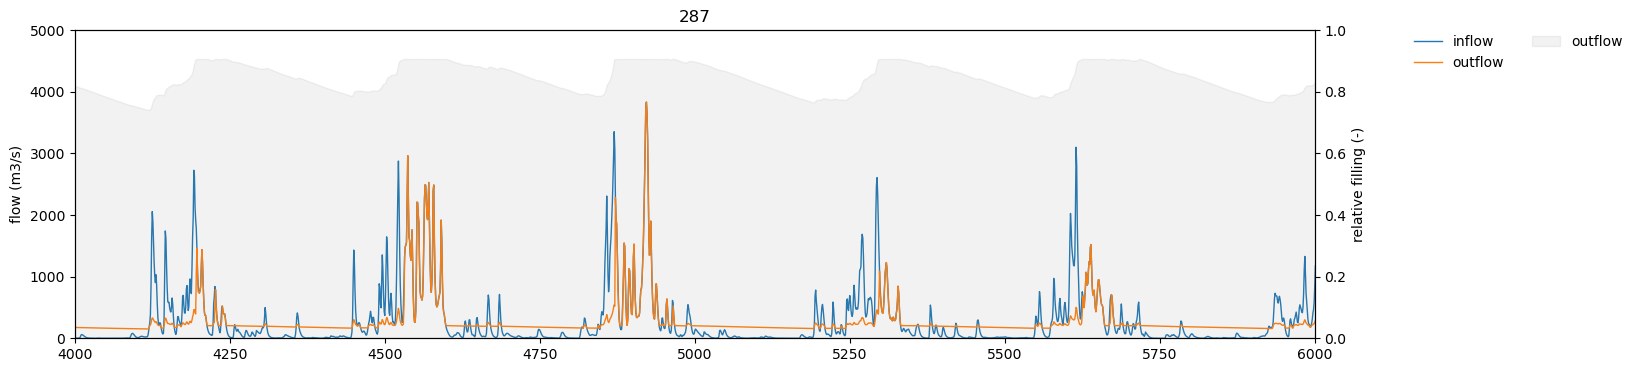

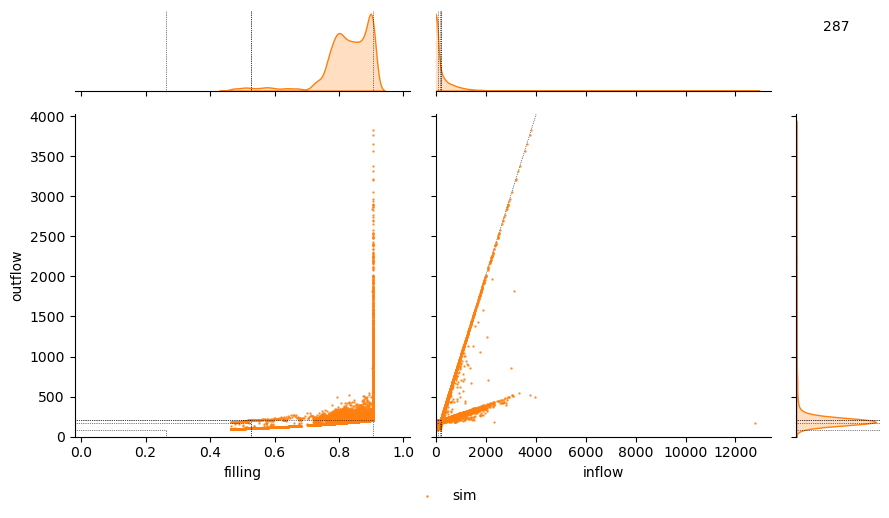

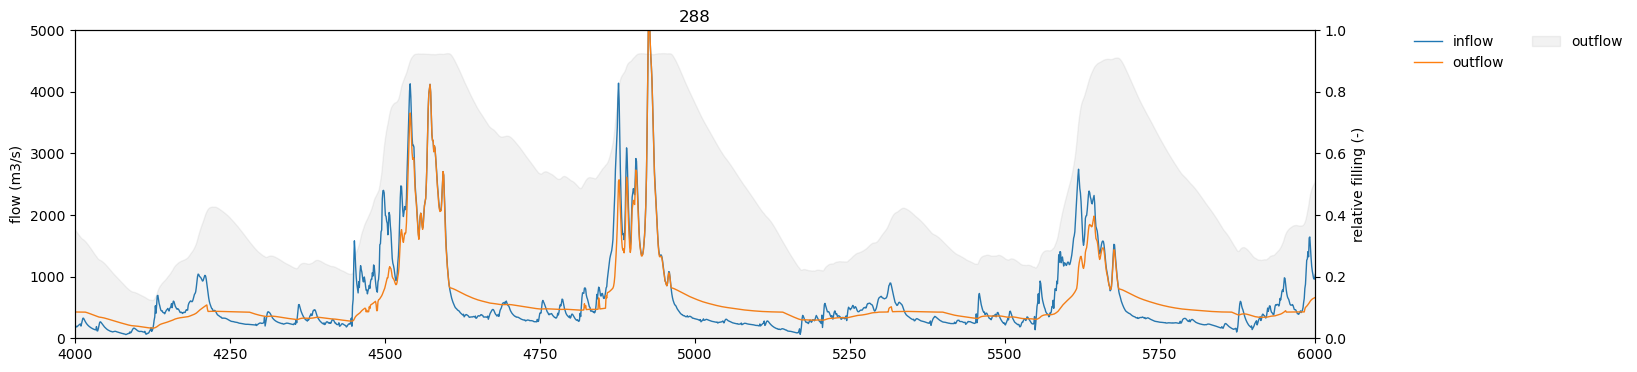

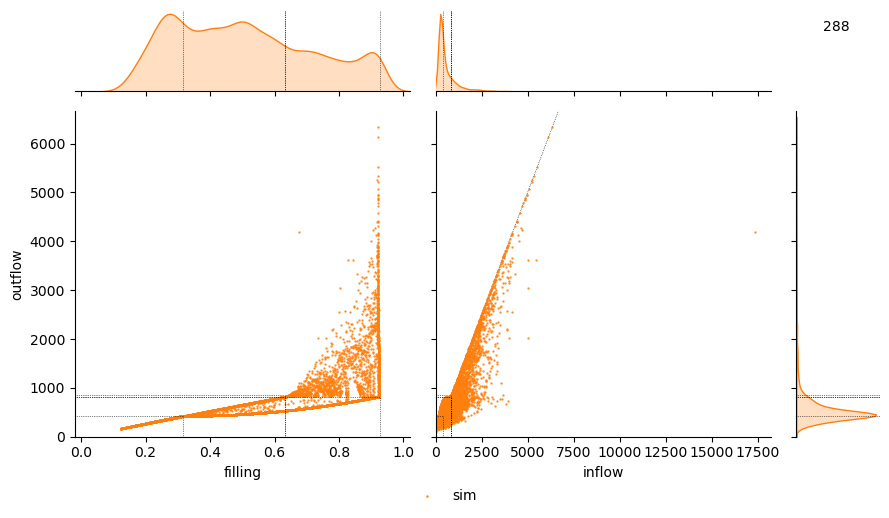

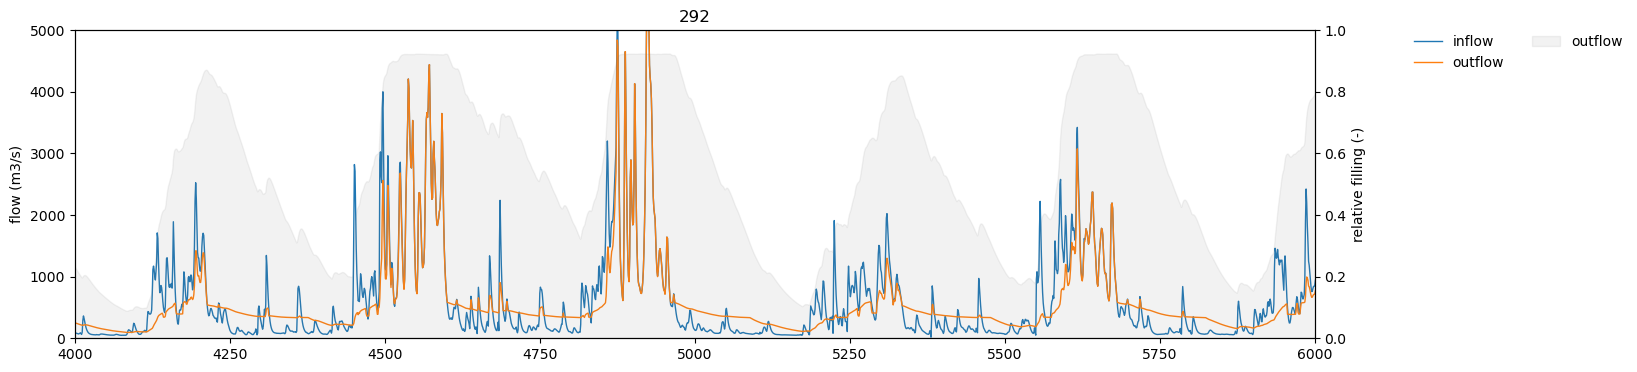

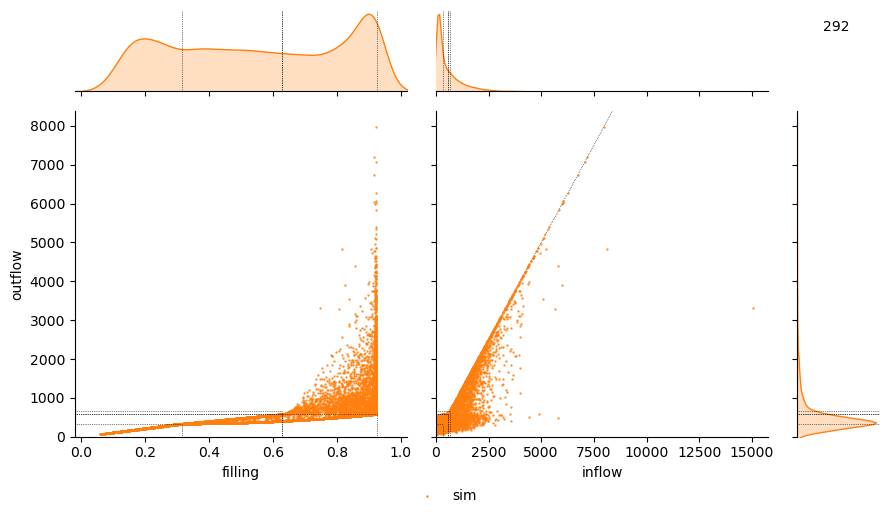

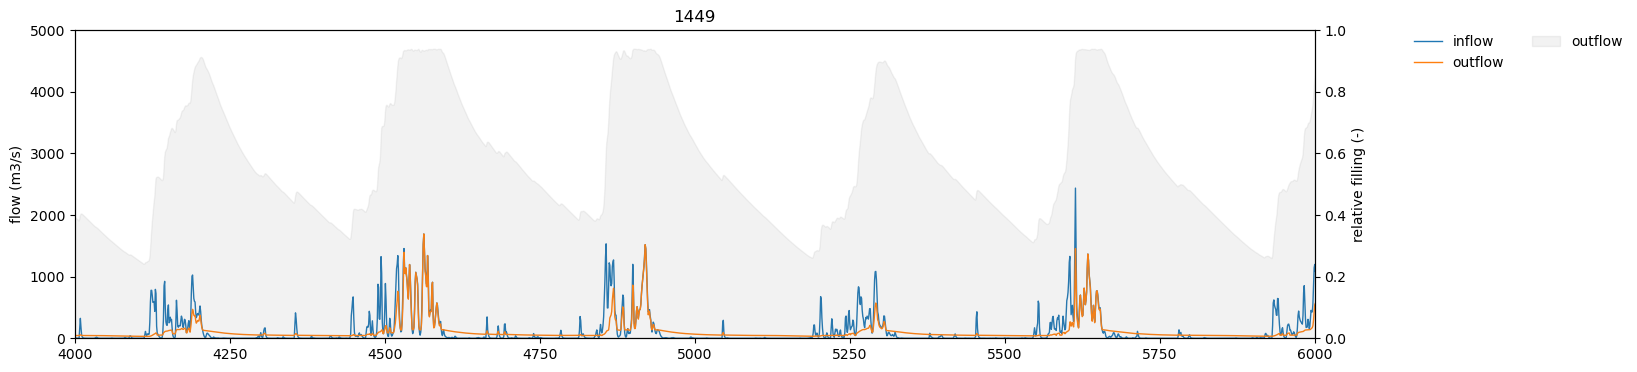

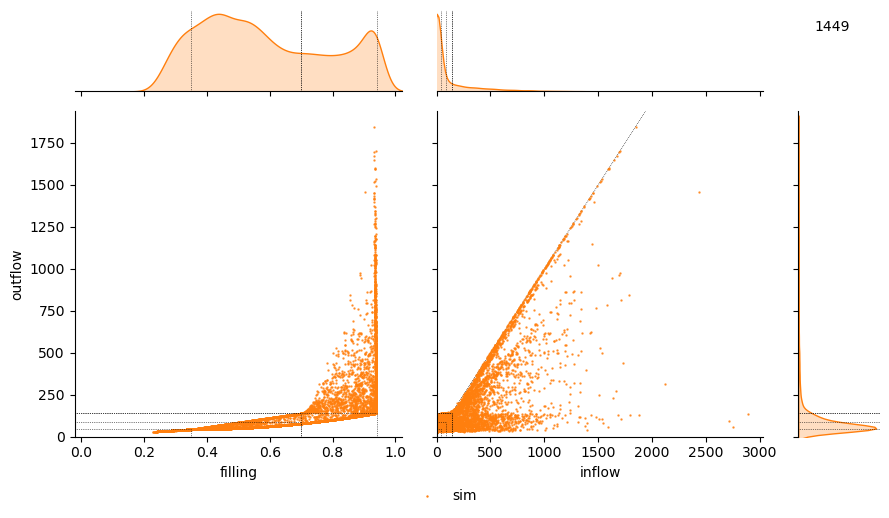

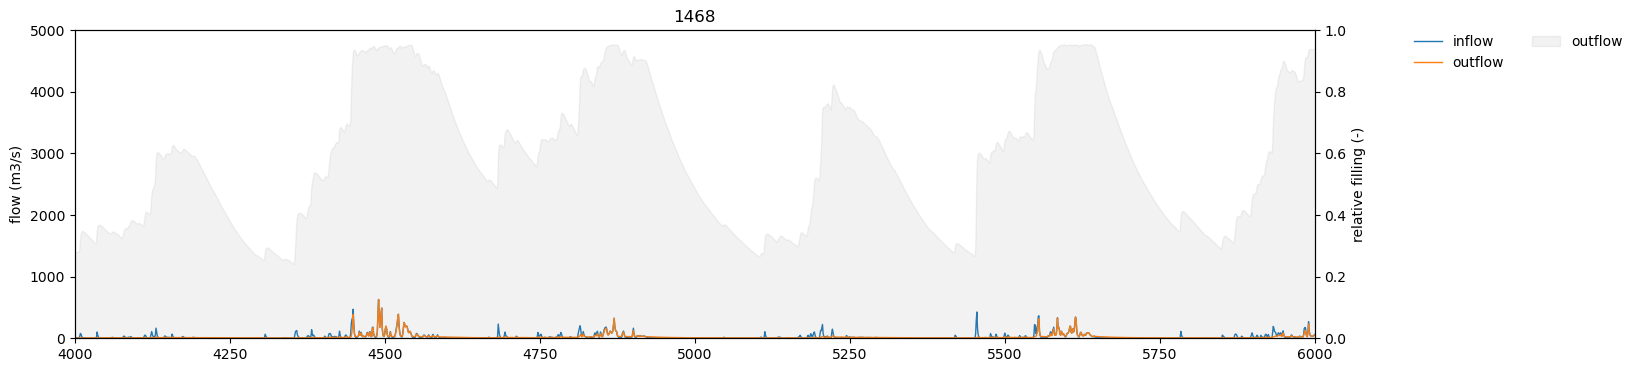

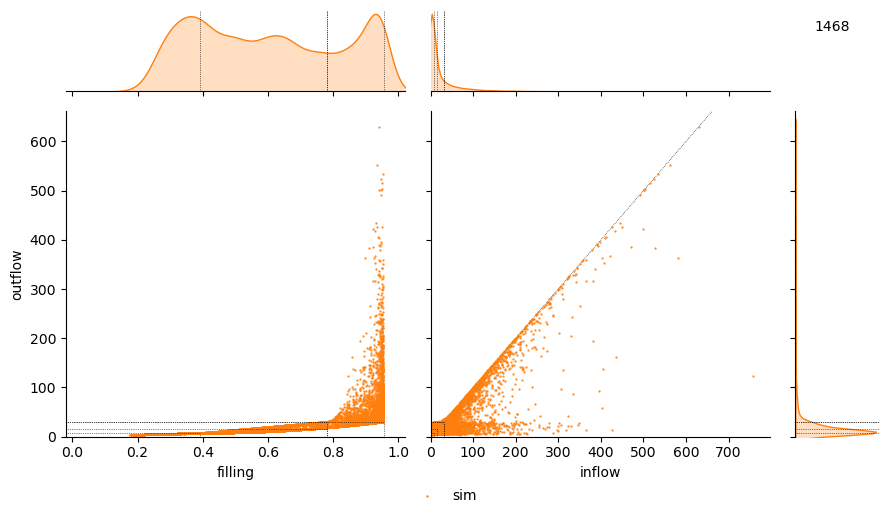

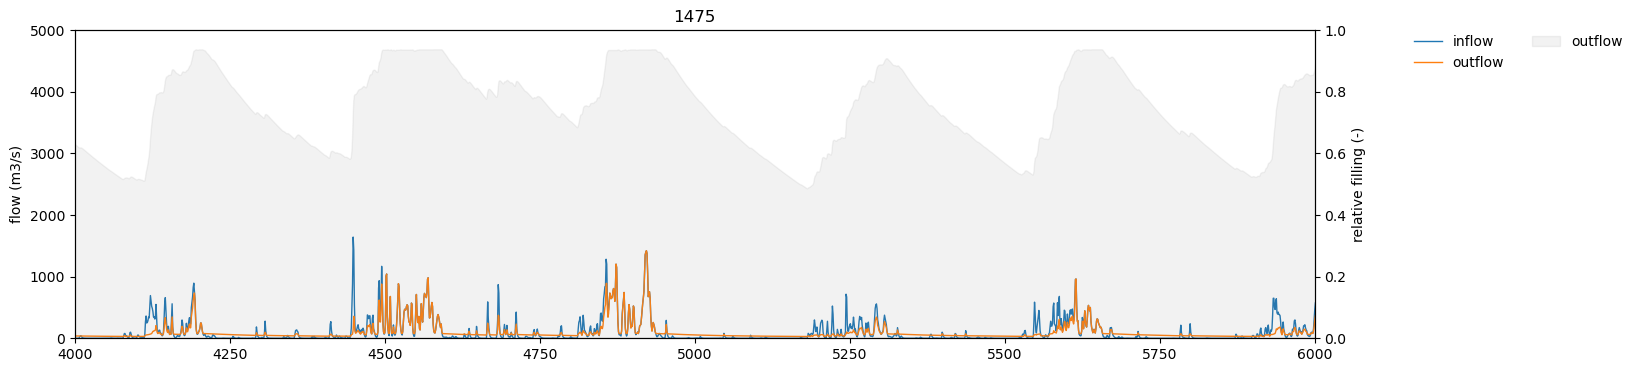

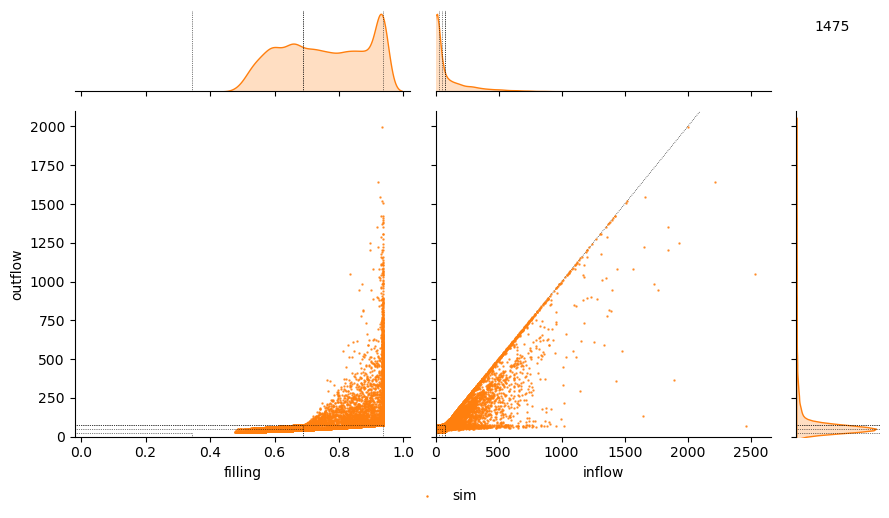

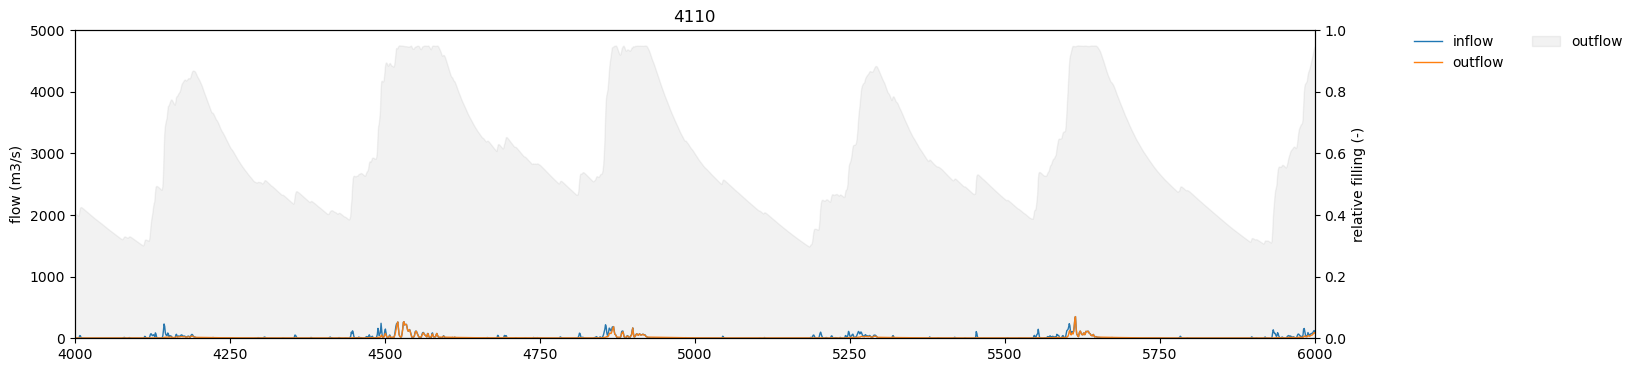

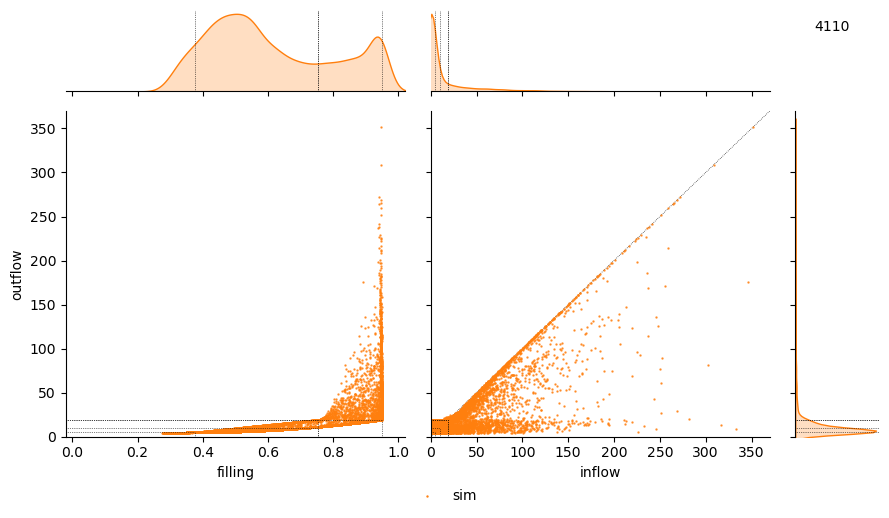

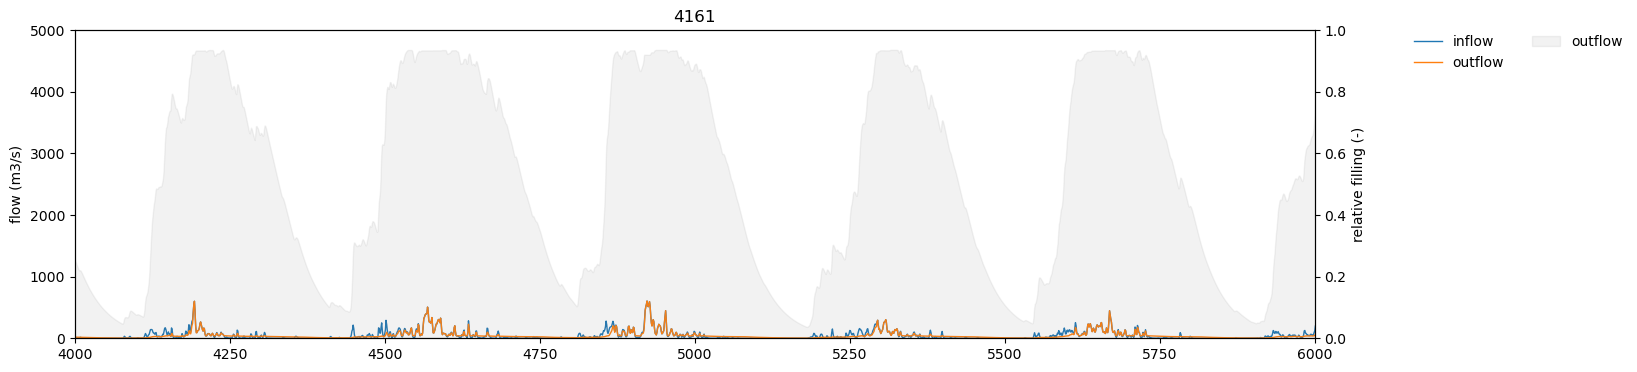

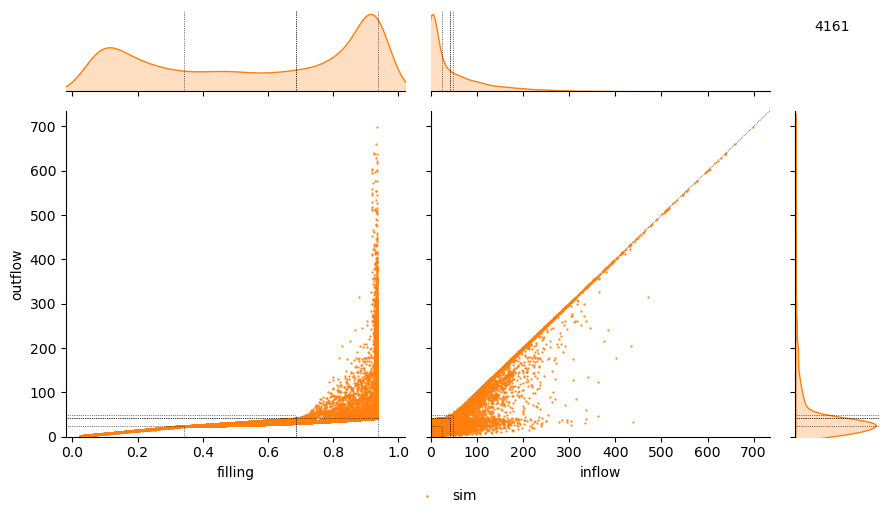

In [22]:
for ID, sim in results.items():
    plot_reservoir(
        sim,
        title=ID,
        xlim=(4000, 6000)
    )
    if ID == observed:
        obs = observed[ID]
    else:
        obs = None
    reservoir_analysis(
        sim=sim,
        obs=None,
        x1='filling',
        x_thr=limits.loc[ID, ['Ve', 'Vf', 'Vf', 'Vc']],
        x2='inflow',
        y='outflow',
        y_thr=limits.loc[ID, ['Qf', 'Qf', 'Qn', 'Qc']],
        xlim=(4000, 6000),
        title=ID,
        alpha=.8
    )